## 1 - Introduction ##

This Notebook shows the calculations of accuracy and precision for the Arrington ViewPoint EyeTracking software with the NordicNeuroLab VisualSystem HD. The notebook is processing n ViewPoint dataFiles which each contains the gaze data for 16 stimulus points with a duration of 3 seconds. Letters from A-P are inserted as markers and identifies the row where a new stimulus point is shown. The notebook will only run if the dataFiles are on this forma. To use the notebook for your specific dataFiles, configure the different functions accordingly.


## 2 - Preprocessing ##

#### 2.1 Loading libraries and defining constants ####

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from scipy import stats
pd.options.mode.chained_assignment = None

We define the path of the ViewPoint dataFiles and VSHD constants as well as the coordinates for each stimulus pointin the ViewPoint coordinate system.

In [86]:
measurement_dir = 'Data/'

VSHD_WIDTH = 1920
VSHD_HEIGHT = 1200

VSHD_VERTICAL_FOV = 34
VSHD_HORIZONTAL_FOV = 52.1

stimpoints_dict =  {
    'A' : [0.30, 0.75],
    'B' : [0.70, 0.25],
    'C' : [0.30, 0.25],
    'D' : [0.70, 0.75],
    'E' : [0.40, 0.60],
    'F' : [0.60, 0.60],
    'G' : [0.40, 0.40],
    'H' : [0.60, 0.40],
    'I' : [0.50, 0.425],
    'J' : [0.50, 0.75],
    'K' : [0.50, 0.25],
    'L' : [0.30, 0.50],
    'M' : [0.50, 0.35],
    'N' : [0.70, 0.50],
    'O' : [0.50, 0.65],
    'P': [0.50, 0.50]
}

Z = 3

From the VSHD parameters we can calculate the distance (in units pixels) from the screen to the observers eyes. 

We choose the point o = (x_0, y_0, z_0) = (0, 0, 0) as the top left of the screen.

In [87]:
distance_eye_screen = (VSHD_WIDTH * 0.5) / ( np.tan(VSHD_HORIZONTAL_FOV * 0.5 * (np.pi / 180) ) )
eye = np.array([0.5 * VSHD_WIDTH, 0.5 * VSHD_HEIGHT, distance_eye_screen])

The stimulus points coordinates needs to be calculated from the ViewPoint coordinates in the stimpoints_dict. The VSHD OLED displays comprise 1920 x 1200 pixels. This corresponds to an aspect ratio of 16:10, while the coordinates provided by ViewPoint corresponds to an aspect ratio of 1:1. Therefore, the x and y coordinates needs to be adjusted. We choose to use pixels as the unit.

In [88]:
stimpoints_dict_normalized = {}
for key, val in stimpoints_dict.items():
    stimpoints_dict_normalized[key] = np.array([val[0] * VSHD_WIDTH, val[1] * VSHD_HEIGHT, 0])


#### 2.2 - Loading data ####
Let's start by reading in all of the ViewPoint recordings as pandas dataframes. We skip the 40 first rows does not contain any useful information. Some rows contains other information than the gaze data specified in the header in row number 41, this will raise an Exception from the Pandas library, we skip these rows as they do not contain useful information for us.

In [89]:

list_files = listdir(measurement_dir)
df_list = []
for f in list_files:
    df = pd.read_csv(measurement_dir + f, 
                     skiprows = 40, 
                     on_bad_lines = 'skip', 
                     delimiter = '\t',
                     )
    df_list.append(df)



#### 2.3 - Inserting markers ####

Next, we need to locate all the markers inserted in the datafile which indicates where a new stimulus point was shown to the subject. Then we insert these markers to the Marker column.

In [90]:
def _get_stimpoint(row):
    if row['Marker'] in stimpoints_dict_normalized.keys():
        return stimpoints_dict_normalized[row['Marker']]
    else:
        return np.nan
    
def insert_stimpoints(df):
    df['Marker'] = df['Marker'].fillna(method = 'ffill')
    df['Target'] = df.apply(_get_stimpoint,  axis = 1)
    return df
    

#### 2.4 - Remove unecessary columns ####

We will also only keep the columns we are interested in, which are the Marker column and the gaze points for each eye. We also get rid of all the row which does not provide useful information by using pandas dropna().

In [91]:
def remove_unecesarry_cols(df):
    df = df[['Marker', 'X_Gaze', 'Y_Gaze', 'X_Gaze.1', 'Y_Gaze.1', 'Target']]
    df = df.dropna()
    return df

#### 2.5 - Calculating mean gaze ####

Now we want to calculate the mean of the gaze points from eye A and eye B into a combined gazepoint AB, for each axis.

In [92]:

def insert_mean_gaze(df):
    df['X_Gaze_AB'] = df[['X_Gaze', 'X_Gaze.1']].mean(axis=1)
    df['Y_Gaze_AB'] = df[['Y_Gaze', 'Y_Gaze.1']].mean(axis=1)
    return df


Again, because of the gaze points are in the ViewPoint coordinate system, we need to normalize them to the VSHD coordinate system (in pixels)

In [93]:

def normalize_to_vshd(df):
    df[['X_Gaze', 'X_Gaze.1', 'X_Gaze_AB']] = df[['X_Gaze', 'X_Gaze.1', 'X_Gaze_AB']].apply(lambda x: x * VSHD_WIDTH)
    df[['Y_Gaze', 'Y_Gaze.1', 'Y_Gaze_AB']] = df[['Y_Gaze', 'Y_Gaze.1', 'Y_Gaze_AB']].apply(lambda x: x * VSHD_HEIGHT)
    return df

Furthermore, the new averaged gaze points will be made into points in our new coordinate system. Now we also can get rid of unecessary columns.

In [94]:
def _get_gaze_point(row):
    return np.array([row['X_Gaze_AB'], row['Y_Gaze_AB'], 0])

def insert_gaze_points_3D(df):
    df['Gaze'] = df.apply(_get_gaze_point, axis = 1)
    df = df[['Marker', 'Gaze', 'Target']]
    return df

#### 2.6 - Calculating angular offset ####

With the three points we have: Eye, Gaze and Target, we define two vectors: Eye to Target, and Eye to Gaze, we then create another column to our dataframe with the angular offset between the two vectors.

In [95]:
def get_angle_between_vectors(v, u):
    v_norm = v / np.linalg.norm(v)
    u_norm = u / np.linalg.norm(u)
    theta = np.arccos(np.clip(np.dot(v_norm, u_norm), -1.0, 1.0))
    return np.degrees(theta)


def _calculate_angle_of_row(row):
    eye_target = eye - row['Target'] 
    eye_gaze = eye - row['Gaze']
    return get_angle_between_vectors(eye_target, eye_gaze)


def insert_angle(df):
    df['Theta'] = df.apply(_calculate_angle_of_row, axis = 1)
    return df

#### 2.7 - Defining the gaze ####

For each stimulus point, we need to calculate the sequence of gaze points that comprise the fixation. 

Each stimulus point was 3 Seconds long. We consider 0.8 - 2.8 seconds to be the 2 seconds of interest. The VSHD EyeTracker measures with a frequency of 60 Hz, meaning we must have datapoint 48 to 168.

In [96]:
def filter_gaze(df):
    filtered_gaze = []
    for key in stimpoints_dict_normalized.keys():
        marker_group = df.loc[df['Marker'] == key]
        marker_group = marker_group.iloc[48:168, :]
        filtered_gaze.append(marker_group)
        
    return pd.concat(filtered_gaze, axis = 0)
        

#### 2.8 - Removing outliers ####

Outliers in the dataset can be caused of saccades, blinks or wrong measurements.

We use a z-score of 3 as a threshold for these outliers, meaning we discard every measurement that is 3 times the standard deviation of the angles within the subjects measurements.

In [97]:
def remove_outliers(df):
    df = df[np.abs(stats.zscore(df['Theta'], ddof = 1)) < Z]
    return df

#### 2.9  - Creating a preprocessing pipeline ####

We collect all our preprocessing steps in a new class PreProcessor

In [98]:
class PreProcessor:

    def __call__(self, df) -> pd.DataFrame:
        df_stim = insert_stimpoints(df)
        df_stripped = remove_unecesarry_cols(df_stim)
        df_mean_gaze = insert_mean_gaze(df_stripped)
        df_normalized = normalize_to_vshd(df_mean_gaze)
        df_gaze_3d = insert_gaze_points_3D(df_normalized)
        df_angle = insert_angle(df_gaze_3d)
        df_filtered_gaze = filter_gaze(df_angle)
        df_no_outliers = remove_outliers(df_filtered_gaze)
        print(f'Removed Outliers, {round(len(df_no_outliers)/len(df_filtered_gaze) * 100, 4)} % of Data was within {Z} Standard Deviations')
        return df_no_outliers


In [99]:
preprocessor = PreProcessor()
preprocessed_df_list = [preprocessor(df) for df in df_list]

Removed Outliers, 98.3152 % of Data was within 3 Standard Deviations
Removed Outliers, 99.2708 % of Data was within 3 Standard Deviations
Removed Outliers, 98.0729 % of Data was within 3 Standard Deviations
Removed Outliers, 99.8958 % of Data was within 3 Standard Deviations
Removed Outliers, 99.8954 % of Data was within 3 Standard Deviations
Removed Outliers, 97.6042 % of Data was within 3 Standard Deviations
Removed Outliers, 98.5938 % of Data was within 3 Standard Deviations
Removed Outliers, 97.7083 % of Data was within 3 Standard Deviations
Removed Outliers, 96.5104 % of Data was within 3 Standard Deviations
Removed Outliers, 98.9062 % of Data was within 3 Standard Deviations
Removed Outliers, 100.0 % of Data was within 3 Standard Deviations


## 3 - Results ##

Let's concatenate all the individual measurements into one large dataframe to see that everything is as expected

In [100]:
review_df = pd.concat(preprocessed_df_list)
review_df

,Marker,Gaze,Target,Theta
581,A,"[548.4479999999999, 951.3, 0.0]","[576.0, 900.0, 0.0]",1.597720
582,A,"[542.4, 944.76, 0.0]","[576.0, 900.0, 0.0]",1.531112
583,A,"[544.512, 949.5, 0.0]","[576.0, 900.0, 0.0]",1.606815
584,A,"[545.2800000000001, 945.06, 0.0]","[576.0, 900.0, 0.0]",1.493437
585,A,"[549.408, 952.6800000000001, 0.0]","[576.0, 900.0, 0.0]",1.620053
...,...,...,...,...
3761,P,"[1024.32, 555.42, 0.0]","[960.0, 600.0, 0.0]",2.281907
3762,P,"[1021.344, 557.1600000000001, 0.0]","[960.0, 600.0, 0.0]",2.181798
3763,P,"[1022.6880000000001, 557.04, 0.0]","[960.0, 600.0, 0.0]",2.215985
3764,P,"[1020.6719999999999, 555.48, 0.0]","[960.0, 600.0, 0.0]",2.194371


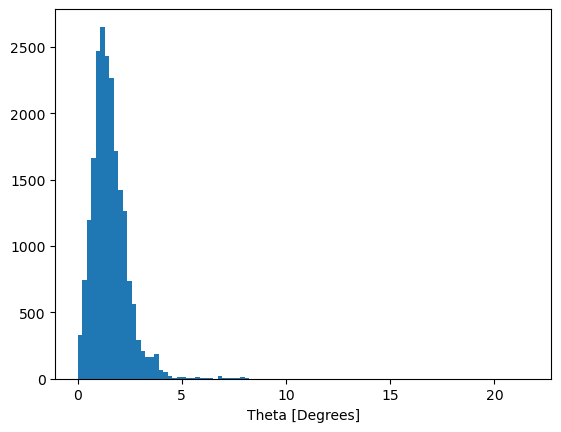

In [101]:
plt.hist(review_df['Theta'], bins = 100)
plt.xlabel('Theta [Degrees]')
plt.show()

Now we are ready to produce the results. We go through each subject and calculate the accuracy and precision.

The accuracy for each subject is defined as the mean angular offset (theta) in degrees of visual angle between the n = 16 measured fixation locations and the corresponding locations of the fixation target.

The precision for each subject is defined as the mean of sample-to-sample movement for each 16 targets.

In [102]:
def rms(df):
    rms = []
    for key in stimpoints_dict_normalized.keys():
        marker_group = df.loc[df['Marker'] == key]
        squared_succesive_angles = []
        for i in range(len(marker_group['Gaze']) - 1):
            eye_gaze_0 = eye - marker_group['Gaze'].iloc[i]
            eye_gaze_1 = eye - marker_group['Gaze'].iloc[i + 1]
            squared_succesive_angles.append(get_angle_between_vectors(eye_gaze_0, eye_gaze_1) ** 2)
        squared_angles_summed = np.sum(squared_succesive_angles)
        rms.append(np.sqrt( squared_angles_summed / len(squared_succesive_angles)))
    return np.mean(rms)


In [103]:
individual_results_df = pd.DataFrame()

individual_results_df['Subject'] = [f'Subject {x + 1}' for x in range(len(preprocessed_df_list))]
individual_results_df['Accuracy (mean)'] = [df['Theta'].mean() for df in preprocessed_df_list]
individual_results_df['Precision (rms)'] = [rms(df) for df in preprocessed_df_list]
individual_results_df.set_index("Subject")

,Accuracy (mean),Precision (rms)
Subject,,
Subject 1,1.550301,0.294925
Subject 2,1.615494,0.175529
Subject 3,1.572250,0.192382
Subject 4,1.546893,0.132783
Subject 5,0.807822,0.138437
Subject 6,2.068126,0.434209
Subject 7,1.314768,0.192399
Subject 8,1.143677,0.174090
Subject 9,1.887403,0.962695


In [104]:
results_df = individual_results_df[['Accuracy (mean)', 'Precision (rms)']].agg(['mean'])
results_df

,Accuracy (mean),Precision (rms)
mean,1.546675,0.281567
